In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

In [6]:
# Load the generated soft labels and CIFAR-10H labels
from soft_label_predictor import ImageHardToSoftLabelModel
from generate_soft_labels import create_soft_label_dataset

# Create soft label dataset using the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = ImageHardToSoftLabelModel().to(device)
model.load_state_dict(torch.load("models/soft_label_model.pt", weights_only=True))

# Create dataloader for CIFAR-10 train set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])
cifar10_train = datasets.CIFAR10(root="../data/cifar-10", train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root="../data/cifar-10", train=False, download=True, transform=transform)

train_loader = DataLoader(cifar10_train, batch_size=128, shuffle=False)
test_loader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

# Generate soft labels (test set on cifar10 is comparable to cifar10h set)
soft_label_dataset = create_soft_label_dataset(model, test_loader, device)
generated_soft_labels = torch.stack([label for _, label in soft_label_dataset]).numpy()
cifar10h_soft_labels = np.load("../data/cifar-10h/cifar10h-probs.npy")

# Load CIFAR-10 dataset to get true labels
transform = transforms.ToTensor()

# Get hard labels
train_labels = np.array([y for _, y in cifar10_train])
test_labels = np.array([y for _, y in cifar10_test])
all_hard_labels = np.concatenate([train_labels, test_labels])

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Helper function to compute statistics
def compute_label_stats(soft_labels, hard_labels):
    stats = {}
    
    # Overall statistics
    soft_label_argmax = np.argmax(soft_labels, axis=1)
    stats['accuracy'] = np.mean(soft_label_argmax == hard_labels)
    stats['avg_confidence'] = np.mean(np.max(soft_labels, axis=1))
    stats['entropy'] = -np.sum(soft_labels * np.log(soft_labels + 1e-10), axis=1).mean()
    
    # Per-class statistics
    class_stats = []
    for i in range(10):
        class_mask = hard_labels == i
        class_dict = {
            'class': i,
            'accuracy': np.mean(soft_label_argmax[class_mask] == hard_labels[class_mask]),
            'confidence': np.mean(np.max(soft_labels[class_mask], axis=1)),
            'entropy': -np.sum(soft_labels[class_mask] * np.log(soft_labels[class_mask] + 1e-10), axis=1).mean()
        }
        class_stats.append(class_dict)
    
    stats['per_class'] = pd.DataFrame(class_stats)
    return stats

print(f"Generated len: {len(generated_soft_labels)}, CIFAR-10H len: {len(cifar10h_soft_labels)}")

# Compute statistics for both sets
gen_stats = compute_label_stats(generated_soft_labels, test_labels)  # First 10k for test set comparison
cifar10h_stats = compute_label_stats(cifar10h_soft_labels, test_labels)

# Print overall statistics comparison
print("=== Overall Statistics Comparison ===")
print(f"Generated Labels:")
print(f"  Accuracy: {gen_stats['accuracy']:.4f}")
print(f"  Avg Confidence: {gen_stats['avg_confidence']:.4f}")
print(f"  Entropy: {gen_stats['entropy']:.4f}")
print(f"\nCIFAR-10H Labels:")
print(f"  Accuracy: {cifar10h_stats['accuracy']:.4f}")
print(f"  Avg Confidence: {cifar10h_stats['avg_confidence']:.4f}")
print(f"  Entropy: {cifar10h_stats['entropy']:.4f}")

Generated len: 10000, CIFAR-10H len: 10000
=== Overall Statistics Comparison ===
Generated Labels:
  Accuracy: 0.9999
  Avg Confidence: 0.9495
  Entropy: 0.2575

CIFAR-10H Labels:
  Accuracy: 0.9921
  Avg Confidence: 0.9544
  Entropy: 0.1545


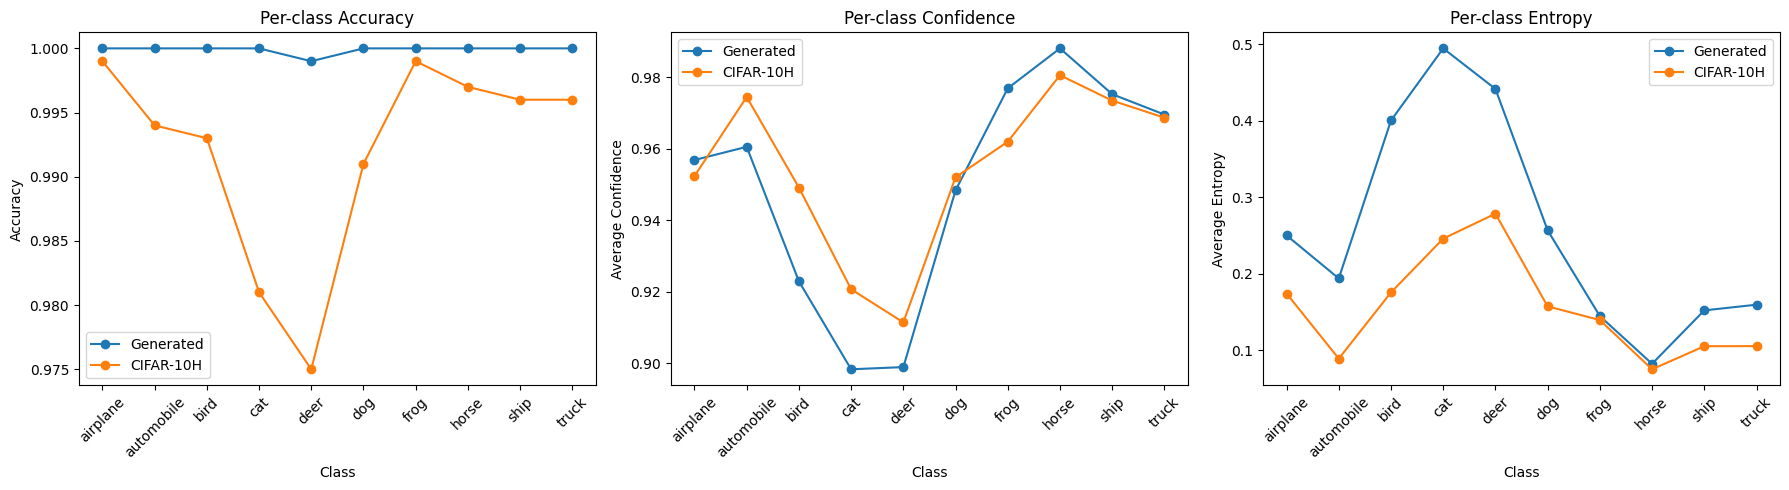

In [15]:
# Plot per-class statistics comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Accuracy comparison
gen_stats['per_class'].plot(x='class', y='accuracy', ax=ax1, marker='o', label='Generated')
cifar10h_stats['per_class'].plot(x='class', y='accuracy', ax=ax1, marker='o', label='CIFAR-10H')
ax1.set_title('Per-class Accuracy')
ax1.set_xlabel('Class')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(10))
ax1.set_xticklabels(class_names, rotation=45)

# Confidence comparison
gen_stats['per_class'].plot(x='class', y='confidence', ax=ax2, marker='o', label='Generated')
cifar10h_stats['per_class'].plot(x='class', y='confidence', ax=ax2, marker='o', label='CIFAR-10H')
ax2.set_title('Per-class Confidence')
ax2.set_xlabel('Class')
ax2.set_ylabel('Average Confidence')
ax2.set_xticks(range(10))
ax2.set_xticklabels(class_names, rotation=45)

# Entropy comparison
gen_stats['per_class'].plot(x='class', y='entropy', ax=ax3, marker='o', label='Generated')
cifar10h_stats['per_class'].plot(x='class', y='entropy', ax=ax3, marker='o', label='CIFAR-10H')
ax3.set_title('Per-class Entropy')
ax3.set_xlabel('Class')
ax3.set_ylabel('Average Entropy')
ax3.set_xticks(range(10))
ax3.set_xticklabels(class_names, rotation=45)

plt.tight_layout()
plt.show()

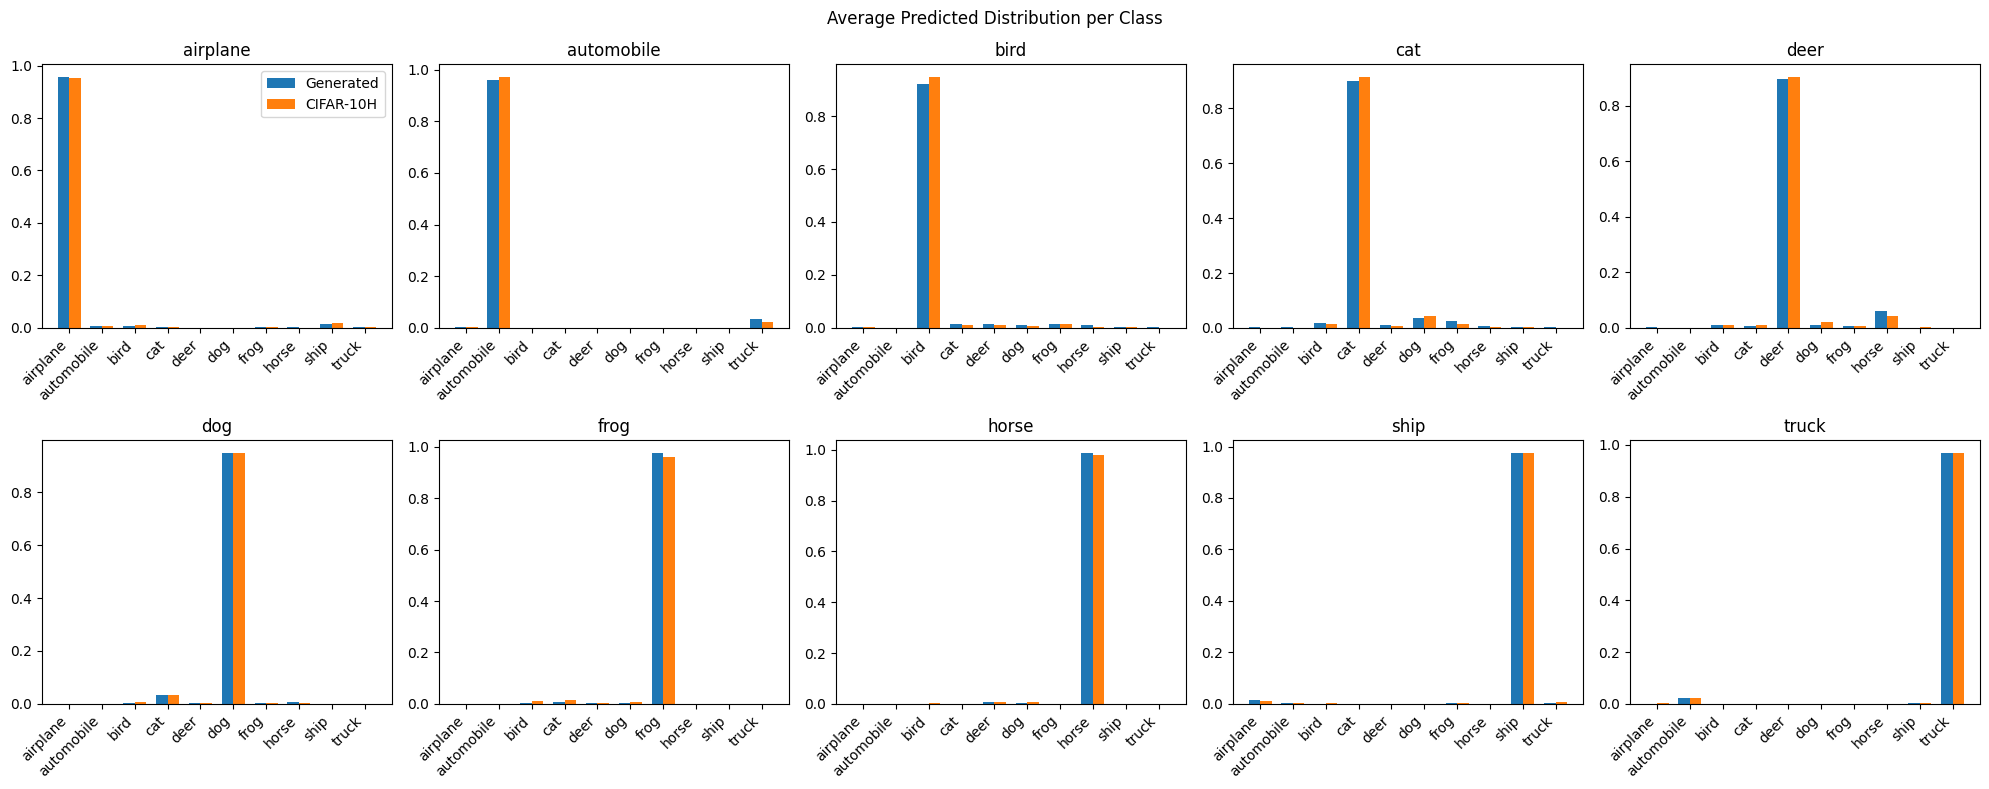

In [16]:
# Plot average distribution for each class
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i in range(10):
    # Get average distributions
    gen_dist = generated_soft_labels[test_labels == i].mean(axis=0)
    cifar10h_dist = cifar10h_soft_labels[test_labels == i].mean(axis=0)
    
    x = np.arange(10)
    width = 0.35
    
    axes[i].bar(x - width/2, gen_dist, width, label='Generated')
    axes[i].bar(x + width/2, cifar10h_dist, width, label='CIFAR-10H')
    axes[i].set_title(f'{class_names[i]}')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(class_names, rotation=45, ha='right')
    if i == 0:
        axes[i].legend()

plt.suptitle('Average Predicted Distribution per Class')
plt.tight_layout()
plt.show()

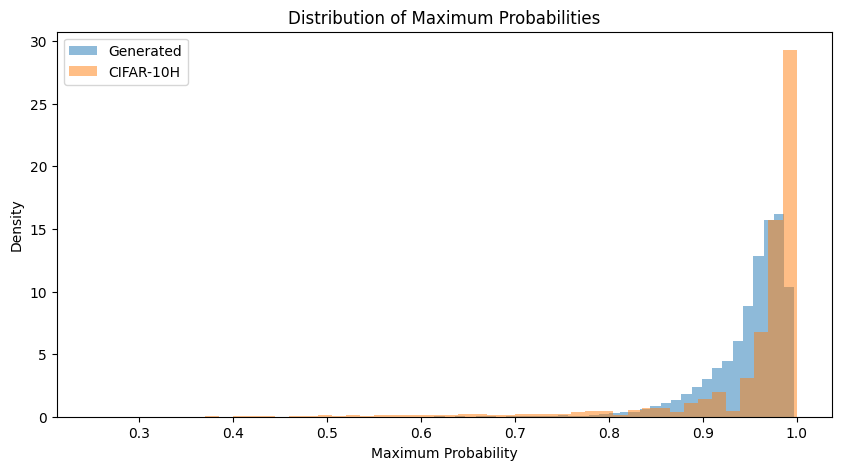

In [12]:
# Plot distribution of maximum probabilities
plt.figure(figsize=(10, 5))
plt.hist(np.max(generated_soft_labels[:10000], axis=1), bins=50, alpha=0.5, label='Generated', density=True)
plt.hist(np.max(cifar10h_soft_labels, axis=1), bins=50, alpha=0.5, label='CIFAR-10H', density=True)
plt.title('Distribution of Maximum Probabilities')
plt.xlabel('Maximum Probability')
plt.ylabel('Density')
plt.legend()
plt.show()